# Time series modelling

Statistical modelling of time series data involves the analysis and interpretation of data points collected <font color='orange'>sequentially over time</font>. 

Time series data often exhibit patterns such as trends, seasonal variations, and irregular fluctuations, making them inherently complex to analyze. 

There exist many statistical models of time series. For example, autoregressive integrated moving average (ARIMA), exponential smoothing methods, and state space models. These models allow for forecasting future values based on past observations.

ARIMA is an abbreviation for  <font color='orange'>autoregressive integrated moving average</font> and these models are what the tin says: they include autoregressive, differencing, and moving average components.

In this lecture we are interested looking at time series structure through the temporal random effects glass. We will consider a specific subclass of ARIMA family. Namely, the autoregressive models.

<font color='orange'>Autoregressive</font> models are statistical models that use a linear combination of past observations of a time series $x_{t-1}, x_{t-2},... $ to predict future values, where each observation is regressed on previous observations.

## Autoregressive model of order 1, AR(1) 

### AR(1) definition
Let us consider AR(1), or Autoregressive model of order 1. In an AR(1) model, each value in the time series $x_t$ is modeled as a linear combination of the previous observation $x_{t-1}$ and a random error term $\epsilon_t$. Mathematically, an AR(1) process can be represented as

```{margin}
The condition $\mid \phi \mid <1$ here is required for stationarity. It comes from the condition that for stationarity, all roots of the characteristic polynomial $\lambda_i$ should satisfy $|\lambda_i|<1.$
```

$$
x_t = \phi x_{t-1} + \epsilon_t,\\
\mid \phi \mid <1,\\
\epsilon_t \sim(0, \sigma^2).
$$


The innovations $\epsilon_t$ are independent from each other.

In many modelling cases, the knowledge of this formulation will suffice for modelling. There is a lot of interesting maths realted to AR models, but we will look at that later. Right now, we are ready to implement AR(1).

### AR(1) implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import jax
import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS

Let's simulate data from AR(1) model.

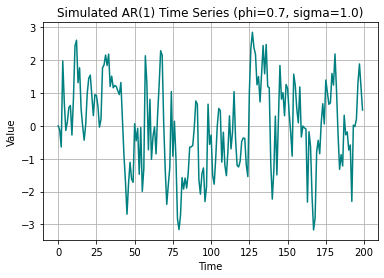

In [16]:
def simulate_ar1(phi, sigma, n):
    """
    Simulate time series data from an AR(1) model.

    Parameters:
        - phi (float): Autoregressive coefficient. Requires -1 < phi < 1.
        - sigma (float): Standard deviation of the white noise.
        - n (int): Length of the time series.

    Returns:
        np.ndarray: Simulated time series data.
    """

    # Initialize array to store simulated data
    ts_data = np.zeros(n)
    
    # Generate white noise
    noise = np.random.normal(0, sigma, n)
    
    # Generate data points using AR(1) process
    for i in range(1, n):
        ts_data[i] = phi * ts_data[i-1] + noise[i]
    
    return ts_data

# Parameters for AR(1) model
phi_true = 0.7    # Autoregressive coefficient
sigma_true = 1.0  # Standard deviation of white noise
n = 200      # Length of time series

# Simulate AR(1) time series data
ts_data = simulate_ar1(phi_true, sigma_true, n)

# Plot the time series data
plt.figure(figsize=(6, 4))
plt.plot(ts_data, color='teal')
plt.title("Simulated AR(1) Time Series (phi={}, sigma={})".format(phi_true, sigma_true))
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()



Can we fit a Numpyro model to this data to estimate $\phi$ and $\sigma$?

```{margin}
Remember plates? *Exercise*: reimplement this model with a loop. What do you observe?
```

In [17]:
def ar1_model(ts_data=None):
    
    # Priors for AR(1) parameters
    phi = numpyro.sample('phi', dist.Normal(0, 1))        # this prior is not quite right. Can you spot why?
    sigma = numpyro.sample('sigma', dist.HalfNormal(1))
    
    # AR(1) model
    with numpyro.plate('data', len(ts_data) - 1):
        numpyro.sample('obs', dist.Normal(phi * ts_data[:-1], sigma), obs=ts_data[1:])

# Inference
nuts_kernel = NUTS(ar1_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, progress_bar=False)
mcmc.run(jax.random.PRNGKey(0), ts_data=ts_data)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       phi      0.69      0.05      0.69      0.61      0.78    711.19      1.00
     sigma      0.97      0.05      0.97      0.90      1.05    959.93      1.00

Number of divergences: 0


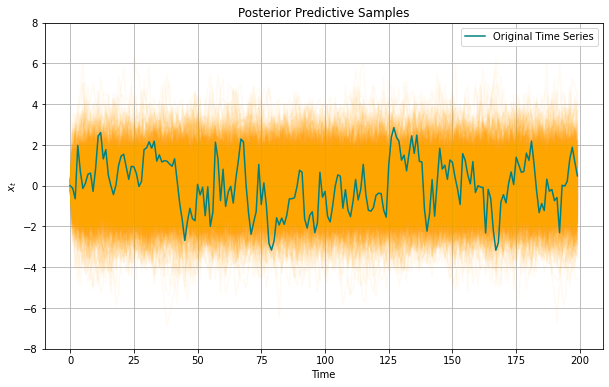

In [18]:
# Posterior predictive samples
posterior_samples = mcmc.get_samples()
phi_samples = posterior_samples['phi']
sigma_samples = posterior_samples['sigma']
posterior_predictive_samples = []

for phi, sigma in zip(phi_samples, sigma_samples):
    ts_data_pred = simulate_ar1(phi, sigma, n)
    posterior_predictive_samples.append(ts_data_pred)

# Plot posterior predictive samples
plt.figure(figsize=(10, 6))
for sample in posterior_predictive_samples:
    plt.plot(sample, alpha=0.05, color='orange')
plt.plot(ts_data, label='Original Time Series', color='teal')
plt.title("Posterior Predictive Samples")
plt.ylim(-8,8)
plt.xlabel("Time")
plt.ylabel("$x_t$")
plt.legend()
plt.grid(True)
plt.show()


Are we happy with this posterior predictive?

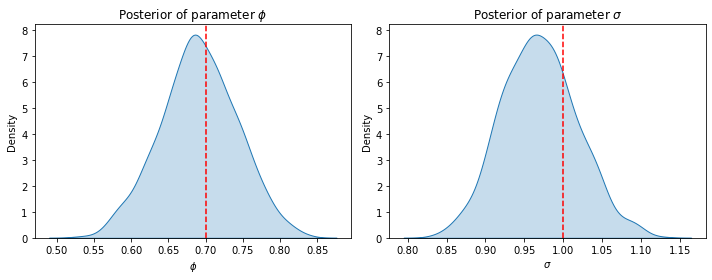

In [19]:
plt.figure(figsize=(10, 4))

# Plot posterior of phi
plt.subplot(1, 2, 1)
sns.kdeplot(phi_samples, fill=True)
plt.axvline(x=phi_true, color='r', linestyle='--', label='True value')
plt.xlabel('$\phi$')
plt.ylabel('Density')
plt.title('Posterior of parameter $\phi$')

# Plot posterior of sigma
plt.subplot(1, 2, 2)
sns.kdeplot(sigma_samples, fill=True)
plt.axvline(x=sigma_true, color='r', linestyle='--', label='True value')
plt.xlabel('$\sigma$')
plt.ylabel('Density')
plt.title('Posterior of parameter $\sigma$')

# Show the plot
plt.tight_layout()
plt.show()


`````{admonition} Group Task 
:class: tip

Experiment with the number of observed data points `n`. How does it affect the estimate of parameter $\phi$?

`````

### AR(1) joint density and precision matrix

We can derive that
```{margin}
Check that you can derive this
```

$$
\begin{aligned}
     &x_1 && \sim \mathcal{N} \left(0, \frac{\sigma^2}{1-\phi^2} \right),\\
     &x_2 \mid x_1 &&\sim \mathcal{N}(\phi x_1, \sigma^2),\\
       &&...\\
     &x_T \mid x_{T-1} &&\sim \mathcal{N}(\phi x_{T-1}, \sigma^2).\\
\end{aligned}
$$

Joint density of $x_1, ..., x_T$, therefore, has the form

```{margin}
recall the pdf of the multivariate Normal distribution which is $\propto \exp{(-x \Sigma^{-1} x^T)}= \exp{(-x Q x^T)}$ if we denote $Q = \Sigma^{=1}$. The matrix $Q$ is called *precision matrix*.
```

$$
\begin{align*}
p(x_1, x_2, ..., x_T) &= p(x_1)p(x_2 \mid x_1) p(x_3 \mid x_2)... p(x_T \mid x_{T-1})\\
& = \mathcal{N}_{x_1} \left(0, \frac{\sigma^2}{1-\phi^2} \right) \times \mathcal{N}_{x_2} \left(\phi x_1,\sigma^2 \right) \times ... \times \mathcal{N}_{x_T} \left(\phi x_{T-1},\sigma^2 \right) = \\
& = \frac{1}{\sqrt{2 \pi * \frac{\sigma^2}{1-\phi^2}}} \exp{\left( - \frac{x_1^2(1-\phi^2)}{\sigma^2} \right)} \times \frac{1}{\sqrt{2 \pi *\sigma^2}} \exp{\left( - \frac{(x_2 - \phi x_1)^2}{\sigma^2} \right)} \times ... \\
&\times \frac{1}{\sqrt{2 \pi *\sigma^2}} \exp{\left( - \frac{(x_T - \phi x_{T-1})^2}{\sigma^2} \right)} \\
& = \sqrt{\frac{1-\phi^2}{(2 \pi *\sigma^2)^T}}\exp{ \left( -\frac{x_1^2(1-\phi^2) + (x_2 - \phi x_1)^2 + ... + (x_T - \phi x_{T-1})^2}{\sigma^2} \right)} \\
& \propto \exp{\left( - (x_1, x_2, ..., x_T) * Q * (x_1, x_2, ..., x_T)^T \right)} = \exp{ (- x Q x^T)}
\end{align*}
$$


The exponent is a quadratic form of $x_1, ..., x_T:$

$$
\begin{align*}
&x_1^2 - \cancel{\phi^2 x_1^2} + \cancel{\phi^2 x_1^2} - 2\phi x_1 x_2 + ( x_2^2 + \phi^2 x_2^2) - 2\phi x_2 x_3 + x_3^2 + ... + (x_{T-1}^2 + \phi^2 x_{T-1}^2) - 2\phi x_{T-1} x_T + x_T^2\\
&= \left( x_1^2 + (1+\phi^2)\sum_{i=2}^{T-1} x_i^2 + x_T^2 \right) -2 \phi \sum_{i=2}^{T-1} x_i x_{i+1}. 
\end{align*}
$$


This quadratic form corresponds to the matrix

$$
Q_\text{AR(1), T} = \frac{1}{\sigma^2} *
\begin{pmatrix}
1 & -\phi & 0 & 0 & ... & 0\\
-\phi & 1 + \phi^2 & -\phi & 0 & ... & 0\\
0 & -\phi & 1 + \phi^2 & -\phi & ... & 0\\
... & ... & ... & ... & ... & ...\\
0 & 0 & 0 & -\phi & 1 + \phi^2 & -\phi \\
0 & 0 & 0 & 0 & -\phi & 1
\end{pmatrix}.
$$

Two observations about this matrix are important:

- its values do not depend on $T$, which is nice propery from modelling perspective: regardless of the number of observed time points, this will always be the same matrix.
- The matrox $Q$ is sparse and is *tridiagnoal* or *banded* .

We could have guessed the banded straucture of AR(1) in advance. This is how:

In general, an element $(i,j)$ of a precision matrix is equal to zero, if and only if $x_i$ and $x_j$ are conditionally independent (i.e. they are independent, given all other entries of vector $x$, accept for $x_i$ and $x_j$; this is usually denoted as $x_{-\{i,j\}}$). Hence, $Q_{(i,j)} = 0$ if and only if partial correlation of $x_i$ and $x_j$ equals zero. Partial autocorrelation (PAC) of an AR(p) process for lags greater than $p$, equals zero. It follows, that an AR(1) precision matrix has banded structure with non-zeros covering the diagonal, one line above the diagonal, and one below.

**Discuss**: What do you think the sparcity pattern will be in the precision matrix of the AR(2) process?






## Autoregressive model of order 2, AR(2) 

### AR(2) definition

AR(2) process $x_t$ can be formulated mathematically as

$$
x_t = \gamma_0 + \gamma_1 \alpha_{t-1} + \gamma_2 \alpha_{t-2} + \epsilon_t, \\
\epsilon_t \sim(0, \sigma^2).
$$

Sometimes it is more convenient to reparametrise AR(2) as

$$
 \begin{align*}
     &\gamma_0 = \lambda \mu,\\
     &\gamma_1 = 2(1-\lambda),\\
     &\gamma_2 = -(1-\lambda).
 \end{align*}
$$

where $\mu \in R, \lambda \in (0,1).$ 

### AR(2) checking stationarity

Let us find conditions on model parameters when AR(2) will be stationary.

For an autoregressive process to be stationary, the roots of its characteristic polynomial (polynomial of the backshift operator $B$) needs to lie outside of the unit circle. The characteristic polynomial here has the form $\Gamma(z) = 1 - \gamma_1 z - \gamma_2 z^2.$ Lengths of its roots are

$$
\begin{align*}
\vert z_{1,2} \vert &= \left\rvert \frac{\gamma_1 \pm \sqrt{\gamma_1^2 + 4\gamma_2}}{2 \gamma_2} \right\rvert \\ 
&= \left\rvert \frac{2(1-\lambda) \pm \sqrt{4(1-\lambda)^2 - 4(1-\lambda)}}{2(1-\lambda)} \right\rvert= \left\rvert \frac{2(1-\lambda) \pm \sqrt{4 - 8\lambda + 4\lambda^2 - 4 + 4\lambda}}{2(1-\lambda)} \right\rvert\\
&= \left\rvert 1 \pm \frac{ 2\sqrt{\lambda(\lambda-1)}}{2(1-\lambda)} \right\rvert.
\end{align*}
$$

If $\lambda(\lambda-1) \ge 0,$ i.e. $\lambda \ge 1$ or $\lambda \le 0,$ then the second root $z_2$ lies within the unit circle and the process is non-stationary. If $\lambda \in (0,1),$ then $\sqrt{\lambda(\lambda-1)} = i \sqrt{\lambda(1-\lambda)},$ and $\vert z_{1,2} \vert = \left\rvert 1 \pm  i \sqrt{\frac{\lambda}{1-\lambda}} \right\rvert = 1 + \frac{\lambda}{1-\lambda} = \frac{1}{1-\lambda},$ which is greater than $1$ for all  $\lambda \in (0,1).$



### AR(2) joint density and precision matrix

All innovations $\epsilon_t$ are independent from each other and stationarity conditions are satisfied. 
As before,

$$
\begin{align*}
     &x_1 \sim N \left( 0, \frac{\sigma^2}{1-\phi_1^2 - \phi_2^2} \right),\\
     &x_2 \mid x_1 \sim N \left( \phi_1 x_1, \sigma^2 \right),\\
     &x_3 \mid x_2, x_1 \sim N \left( \phi_1 x_2 + \phi_2 x_1, \sigma^2 \right),\\
     & ...,\\
     &x_T \mid x_{T-1}, x_{T-2} \sim N \left( \phi_1 x_{T-1} + \phi_2 x_{T-2}, \sigma^2 \right).\\
 \end{align*}
$$

`````{admonition} Task 20
:class: tip

- Continue from here and derive precision matrix of AR(2) for $T=5$.
- Hint: before computing the matrix, can we predict anything about its structure?
- What can we say about this matrix if $\phi_2=0$?

`````


### AR(2) implementation


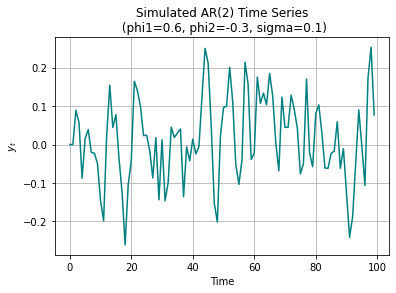

In [21]:
# Generate synthetic data
phi1_true = 0.6
phi2_true = -0.3
sigma_true = 0.1
y0 = 0.0
y1 = 0.0
num_samples = 100
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(num_samples,))
y = jnp.zeros(num_samples)
y = y.at[0].set(y0)
y = y.at[1].set(y1)
for t in range(2, num_samples):
    y = y.at[t].set(phi1_true * y[t-1] + phi2_true * y[t-2] + sigma_true * noise[t])


# Plot the time series data
plt.figure(figsize=(6, 4))
plt.plot(y, color='teal')
plt.title("Simulated AR(2) Time Series\n (phi1={}, phi2={}, sigma={})".format(phi1_true, phi2_true, sigma_true))
plt.xlabel("Time")
plt.ylabel("$y_t$")
plt.grid(True)
plt.show()

In [22]:
def ar2_model(y):
    # Priors for AR coefficients
    phi1 = numpyro.sample('phi1', dist.Normal(0, 1))
    phi2 = numpyro.sample('phi2', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    
    # Define the AR(2) process
    for t in range(2, len(y)):
        mean = phi1 * y[t-1] + phi2 * y[t-2]
        numpyro.sample(f'y_{t}', dist.Normal(mean, sigma), obs=y[t])


# Inference
nuts_kernel = NUTS(ar2_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, progress_bar=False)
mcmc.run(jax.random.PRNGKey(42), y=y) 
mcmc.print_summary()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      phi1      0.61      0.10      0.61      0.44      0.76    766.40      1.00
      phi2     -0.29      0.11     -0.28     -0.47     -0.13    752.24      1.00
     sigma      0.09      0.01      0.09      0.08      0.11    720.60      1.00

Number of divergences: 0


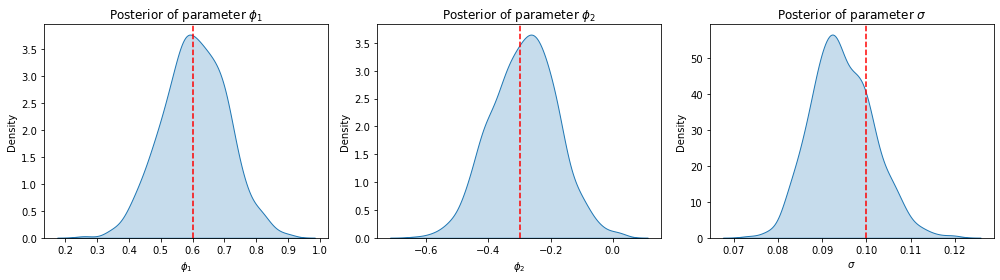

In [23]:
posterior_samples = mcmc.get_samples()
phi1_samples = posterior_samples['phi1']
phi2_samples = posterior_samples['phi2']
sigma_samples = posterior_samples['sigma']

plt.figure(figsize=(14, 4))

# Plot posterior of phi1
plt.subplot(1, 3, 1)
sns.kdeplot(phi1_samples, fill=True)
plt.axvline(x=phi1_true, color='r', linestyle='--', label='True value')
plt.xlabel('$\phi_1$')
plt.ylabel('Density')
plt.title('Posterior of parameter $\phi_1$')

# Plot posterior of phi2
plt.subplot(1, 3, 2)
sns.kdeplot(phi2_samples, fill=True)
plt.axvline(x=phi2_true, color='r', linestyle='--', label='True value')
plt.xlabel('$\phi_2$')
plt.ylabel('Density')
plt.title('Posterior of parameter $\phi_2$')

# Plot posterior of sigma
plt.subplot(1, 3, 3)
sns.kdeplot(sigma_samples, fill=True)
plt.axvline(x=sigma_true, color='r', linestyle='--', label='True value')
plt.xlabel('$\sigma$')
plt.ylabel('Density')
plt.title('Posterior of parameter $\sigma$')

# Show the plot
plt.tight_layout()
plt.show()

## Random walk model

Another class of widely used models for time series datat is the random walk. It is a stochastic process where future values are dependent on the current value and a random shock. Here's a description of the random walk model:

$$
x_t = x_{t-1} + \epsilon_t.
$$

Here $\epsilon_t$ are the innovations which are independent from all previous values of $x_i, i <= t-1.$ Commonly it is assumed that 

$$
\epsilon_t \sim \mathcal{N}(0,\sigma^2).
$$

Under the random walk model each new value depends on the previous value plus a random shock. It implies that future values are unpredictable based solely on past values, making it non-stationary. Despite its simplicity, it's widely used in various fields like finance. The model captures trends and path-dependent volatility but doesn't account for other factors influencing the series.

As a result of adding a random shock to the current value to obtain the next value, the random walk model implies that future values are unpredictable based solely on the past values. The randomness introduced by the shocks makes the series non-stationary.

The random walk model is non-stationary because its variance changes over time:

$$
\text{Var}[x_t] = \text{Var}[x_{t-1}] + \text{Var}[\epsilon_t]
$$

Let us illustrate random walk model with a simulation.

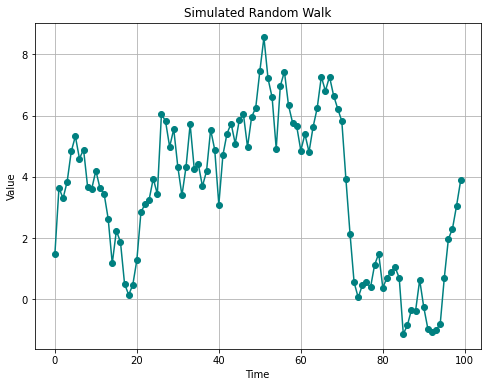

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_random_walk(num_steps, sigma):
    # Generate random shocks
    shocks = np.random.normal(0, sigma, size=num_steps)
    
    # Accumulate shocks to get the random walk path
    random_walk = np.cumsum(shocks)
    
    return random_walk

# Parameters
num_steps = 100  # Number of time steps
sigma = 1.0      # Standard deviation of the random shocks

# Simulate random walk data
random_walk_data = simulate_random_walk(num_steps, sigma)

# Plot the random walk path
plt.figure(figsize=(8, 6))
plt.plot(random_walk_data, marker='o', linestyle='-', color='teal')
plt.title("Simulated Random Walk")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()


`````{admonition} Group Task 
:class: tip

Qualitatitvely, what can you tell about this trajectory as opposed to the AR(1)?

`````

`````{admonition} Task 21
:class: tip

- Implement the random walk model. You may find some inspiration [here](https://num.pyro.ai/en/latest/examples/mortality.html). 
- Fit the model to the simulated data. How well is the model able to recover the parameters?
- Perform posterior predictive check and visualise it.

`````